In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Activation , Dropout
from tensorflow.keras.regularizers import l2

In [ ]:
Covoid_dataset_dir = "../input/covid19-radiography-dataset/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset"
batch_size = 16
img_height = 64
img_width = 64


In [ ]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=(64,64), batch_size=16,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    Covoid_dataset_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False 
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range= 40, #
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range= 0.2,
      shear_range=0.2, zoom_range= 0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    Covoid_dataset_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 4232 images belonging to 4 classes.
Found 16933 images belonging to 4 classes.


In [ ]:
model = Sequential()
# Padding = 'same'  results in padding the input such that
# the output has the same length as the original input
#activation function is to introduce non-linearity into the output of a neuron.
model.add(Conv2D(16, (3, 3), padding='same',
                 input_shape= (64, 64, 3),activation = 'relu'))


model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D())
#model.add(Dropout(0.3))  

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
#model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2)) 
model.add(Dense(units = 81, activation = 'relu'))
model.add(Dense(units = 128 , activation = 'relu'))
# model.add(Dense(units = 81, activation = 'relu'))
# model.add(Dense(units = 32, activation = 'relu'))
# model.add(Dense(units = 16, activation = 'relu'))
# model.add(Dense(units = 8, activation = 'relu'))
# model.add(Dense(units = 4, activation = 'relu'))
model.add(Dense(4))
model.add(Activation('softmax'))

model.summary()






Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 64, 64, 16)        448       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 62, 62, 32)        4640      
_________________________________________________________________
activation_36 (Activation)   (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 31, 31, 64)        18496     
_________________________________________________________________
activation_37 (Activation)   (None, 31, 31, 64)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 15, 15, 64)       

In [ ]:
# initiate RMSprop optimizer and configure some parameters
#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

                      
checkpoint = ModelCheckpoint("COVix.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)
                                    
    
earlystop = EarlyStopping(monitor = 'val_loss', #value being monitored for improvement
                          min_delta = 0.001,  #Abs value and is the main change required before we stop
                          patience = 3, #no of epocs we wait before stopping
                          verbose = 1,
                          restore_best_weights = True) #keep the best weigts once stopped

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.1,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr = 0.001),
              metrics = ['accuracy'])

nb_train_samples = 16933
nb_validation_samples = 4232
epochs = 25

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 16933 // 16,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = valid_generator,
    validation_steps = 4232// 16)

Epoch 1/25
1058/1058 [==============================] - 141s 133ms/step - loss: 0.8619 - accuracy: 0.6362 - val_loss: 0.4899 - val_accuracy: 0.8142

Epoch 00001: val_loss improved from inf to 0.48985, saving model to COVix.h5
Epoch 2/25
1058/1058 [==============================] - 140s 133ms/step - loss: 0.4984 - accuracy: 0.8096 - val_loss: 0.3821 - val_accuracy: 0.8556

Epoch 00002: val_loss improved from 0.48985 to 0.38208, saving model to COVix.h5
Epoch 3/25
1058/1058 [==============================] - 139s 131ms/step - loss: 0.3801 - accuracy: 0.8545 - val_loss: 0.3732 - val_accuracy: 0.8632

Epoch 00003: val_loss improved from 0.38208 to 0.37323, saving model to COVix.h5
Epoch 4/25
1058/1058 [==============================] - 138s 130ms/step - loss: 0.3089 - accuracy: 0.8810 - val_loss: 0.3564 - val_accuracy: 0.8710

Epoch 00004: val_loss improved from 0.37323 to 0.35643, saving model to COVix.h5
Epoch 5/25
1058/1058 [==============================] - 138s 131ms/step - loss: 0.24

In [ ]:
#get the keys of history object
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

Text(0.5, 0, 'epoch')

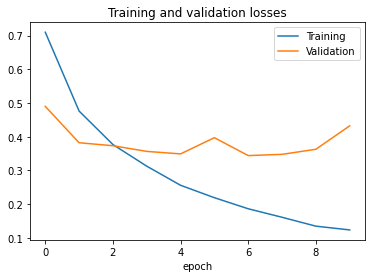

In [ ]:
#plot graph between training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and validation losses')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

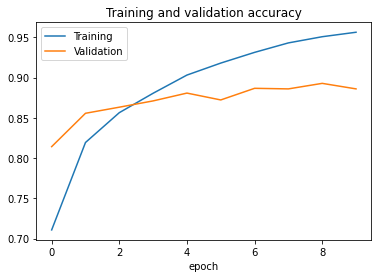

In [ ]:
#plot graph between training and validation accuarcy
#plot graph between training and validation loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and validation accuracy')
plt.xlabel('epoch')

In [ ]:
import numpy as np
import keras
from keras.preprocessing import image
from keras.models import load_model

classifier = load_model('./COVix.h5')
test_image = image.load_img('../input/covid899ttt/covidii.png',target_size = (64,64))


test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image,axis = 0)
result = classifier.predict(test_image)
#result = [[0 ]]

if result[0][0]== 1:
    prediction = 'COVID'
    print(prediction)
elif result[0][0]==2:
    prediction='Lung_Opacity'
    print(prediction)
elif result[0][0]==3:
    prediction='Normal'
    print(prediction)
else:
    print('Viral_pneumonia')

    

COVID


In [ ]:
# Displaying our Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib
#Confution Matrix and Classification Report
class_labels = { 0:"COVID", 1:"Lung_Opacity", 2:"Normal", 3:"Viral Pneumonia"}
Y_pred = classifier.predict_generator(valid_generator, nb_validation_samples // batch_size+1) # put classifier not model
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(valid_generator.classes, y_pred, target_names=target_names))



/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[ 624   44   52    3]
 [  23  977  200    2]
 [  41   72 1918    7]
 [   5    3   28  233]]
Classification Report
                 precision    recall  f1-score   support

          COVID       0.90      0.86      0.88       723
   Lung_Opacity       0.89      0.81      0.85      1202
         Normal       0.87      0.94      0.91      2038
Viral Pneumonia       0.95      0.87      0.91       269

       accuracy                           0.89      4232
      macro avg       0.90      0.87      0.89      4232
   weighted avg       0.89      0.89      0.89      4232



/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


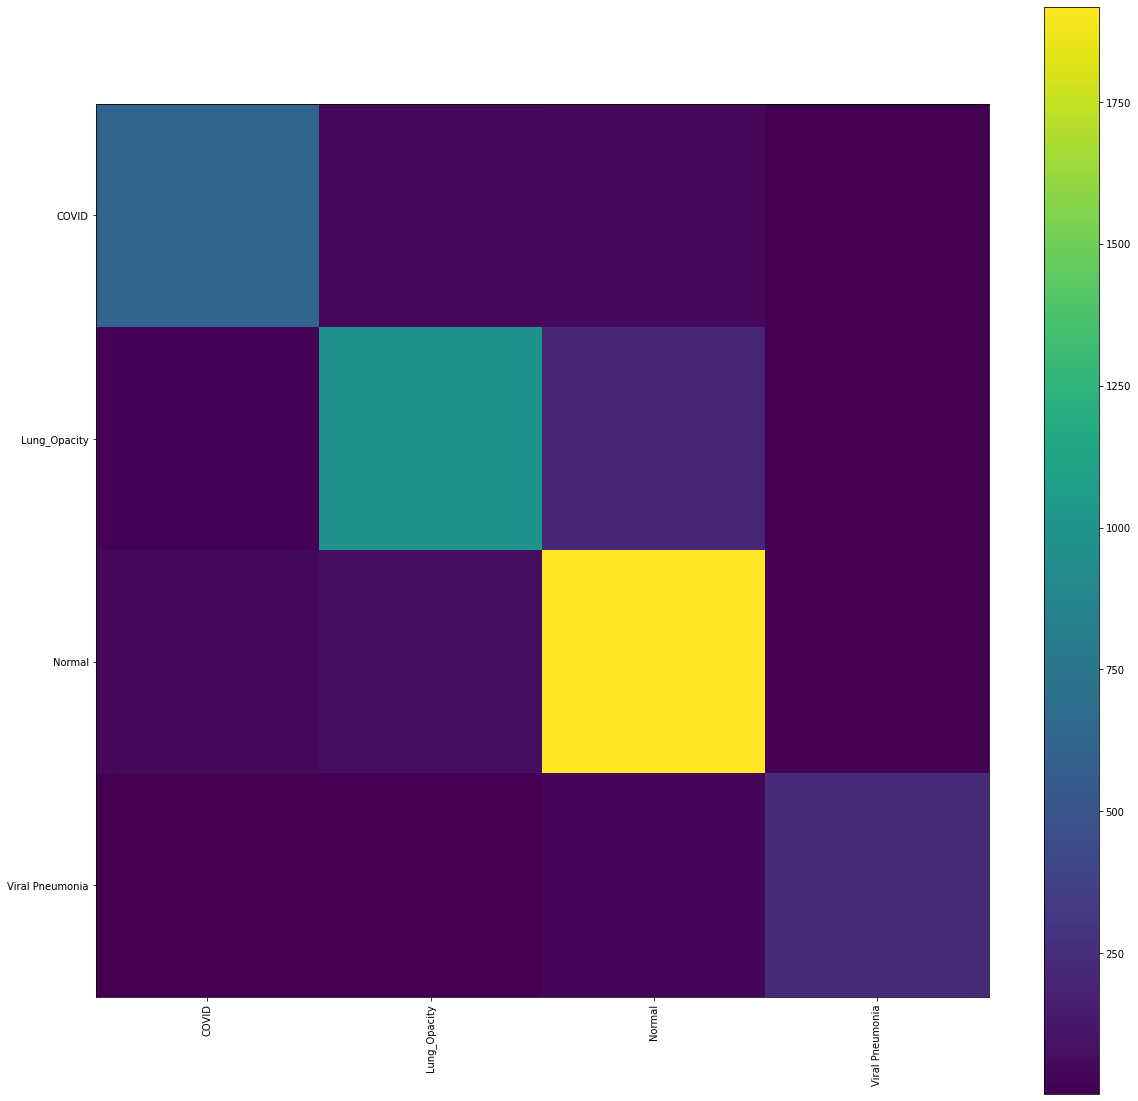

In [ ]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.models import load_model

img_row, img_height, img_depth = 32,32,3
model = load_model('./COVix.h5')

class_labels = valid_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

nb_train_samples = 16933
nb_validation_samples = 4232

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(valid_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

target_names = list(class_labels.values())

plt.figure(figsize=(20,20))
cnf_matrix = confusion_matrix(valid_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)